# Optimized Deep Learning for Single-Subject Analysis
This notebook goes through the process of defining a custom neural network using TensorFlow. 

## Environment setup and tensorflow structure creation

---- Note that MNE saves its data in V not microVolts (*1e6 is needed for plotting)


In [1]:
from ipdb import set_trace
import itertools
import shutil
import sys
from functools import reduce

import matplotlib.pyplot as plt
import sklearn as sk
import tensorflow as tf
from sklearn import linear_model, svm
from sklearn.model_selection import cross_val_score, LeaveOneOut
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.externals.joblib import Memory
from sklearn.preprocessing.data import QuantileTransformer
import mne
from mne.decoding import CSP
from mne.decoding import Vectorizer
from mne.viz import plot_connectivity_circle, plot_topomap
from mne.connectivity import spectral_connectivity
from numpy.random import randint
import numpy as np
from scipy.signal import hilbert
import seaborn as sns
import pandas as pd
import plotly.offline as py
import plotly.tools as tls
import plotly.figure_factory as ff
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold



memory = Memory(cachedir='./tmp', verbose=0)

import lmblab_datasets as ds
import roitools
from study import electrodes
from flip_gradient import flip_gradient

%load_ext memory_profiler
%matplotlib notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### Define what is to comprise the problem (classes, subjects)

In [83]:
#%debug
mne.set_log_level(verbose='WARNING')
%memit b2p, b2p_df = ds.b2p_p3(False)
%memit b2p_long = ds.b2p_p3_long(False, False)

peak memory: 11059.71 MiB, increment: 3124.02 MiB
peak memory: 19990.04 MiB, increment: 8930.32 MiB
peak memory: 23362.61 MiB, increment: 3372.57 MiB


In [10]:
#%debug
b2p.compute_single_trials()
b2p_long.compute_single_trials()

In [11]:
def format_single_group(data, conditions = ['Standard', 'Frequency Deviant', 'Duration Deviant']):#, 'Frequency Deviant' ,  'Duration Deviant']):#, 'Intensity Deviant']):
    X = []
    yc = []
    y = []
    subject = []
    ss = 0
    n = 36
    cut_sample = 128
    cut_end = 460
    
    for g, group in enumerate(data):
        for s in range(len(group[conditions[0]])):
            sub = {c : group[c][s] for c in conditions}
            for c, condition in enumerate(conditions):
                #KEEP ALL CONDITIONS OF SAME TRIAL NUMBER
                
                data = sub[condition].get_data()
                
                trials = data.shape[0]
                if trials < n:
                    data = np.concatenate([data[:,:,cut_sample:cut_end], data[np.random.choice(trials, n - trials, replace = True), :, cut_sample:cut_end]])
                else:
                    data = data[np.random.choice(trials, n, replace = False), :, cut_sample:cut_end]
                
                #Create tmp for 
                if c == 0:
                    tmp = data
                    yc = [c] * n
                    y_tmp = [g] * n
                    subject_tmp = [ss] * n
                    
                else:
                    tmp = np.concatenate([tmp, data], axis = 1)
            ss += 1
                

            y.append(np.array(y_tmp))
            subject.append(np.array(subject_tmp))
            X.append(tmp)
            
    return (np.stack(X), np.stack(y), np.stack(subject))

In [12]:
# %%debug
np.random.seed(seed=1337)
All_X, All_y, All_subs = format_single_group([b2p.single_trial_data['controls'], 
                                  b2p.single_trial_data['concussed']])
X_long, y_long, subs_long = format_single_group([b2p_long.single_trial_data['concussed']])
#X, y, subs = format_single(cfl.single_trial_data['controls'])
info = b2p['controls'][0].data['Duration Deviant'].info

In [13]:
import gc
del cfl
del b2p
del b2p_long
gc.collect()
All_X *= 1e6
X_long *= 1e6

In [14]:
b2p_df['Symptoms'] = np.where(b2p_df['pcss_after'] == 0, 'SR', 'NSR')
b2p_df['Symptoms'] = np.where(b2p_df['pcss_after'] == -1, np.nan, b2p_df['Symptoms'])

In [20]:
# Compare Control to Concussed Young
def control_to_concussed_young():
    l0 = 0
    l2 = 1
    X = np.delete(All_X, np.where((All_y[:,0] == l0) | (All_y[:,0] == l2))[0], axis = 0)
    y = np.delete(All_y, np.where((All_y[:,0] == l0) | (All_y[:,0] == l2))[0], axis = 0)
    subs = np.delete(All_subs, np.where((All_y[:,0] == l0) | (All_y[:,0] == l2))[0], axis = 0)

    labels = np.unique(y)
    y[np.where(y == labels[0])] = 0
    y[np.where(y == labels[1])] = 1
    
    return (X, y, subs)

In [21]:
comparisons = {
    'CONT_CONC_YOUNG': control_to_concussed_young
}

In [22]:
def prep_data(comparison = None):
    if comparison is None:
        X = All_X
        y = All_y
        subs = All_subs

        # Compare All concussed to all control
        y[np.where(y == 2)] = 0
        y[np.where(y == 3)] = 1
    else:
        X, y, subs = comparisons[comparison]()
        
    sub_mapping = {}
    for i, sub in enumerate(np.unique(subs)):
        sub_mapping[i] = sub
        subs[subs == sub] = i
    
    return (X, y, subs, sub_mapping)

In [23]:
class CNNModel(object):
    def __init__(self, nOfClasses, maps, batch_size, f_layers=[50, 100]):
        self.f_layers = f_layers
        self.nOfClasses = nOfClasses
        self.maps = maps
        self.batch_size = batch_size
        self._build_model_conv()
        
    def _build_model_conv(self):
        self.X = tf.placeholder(tf.float32, [None, input_size[0], input_size[1]], name='X') # Input data
        self.X_mod = tf.reshape(self.X, [-1, input_size[0], input_size[1], 1])
        self.Y_ind = tf.placeholder(tf.int32, [None], name='Y_ind')  # Class index
        self.train = tf.placeholder(tf.bool, [], name='train')       # Switch for routing data to class predictor
        self.tempMaps = 1
        new_time = input_size[1]
        
        l2_scale = 0.25
        l1_scale = 0.0

        Y = tf.one_hot(self.Y_ind, self.nOfClasses)
        

        with tf.variable_scope('feature_extractor'): 
            self.conv1 = tf.layers.conv2d(
                    inputs=tf.slice(self.X_mod, [0, 0, 0, 0], [-1, input_size[0]//3, new_time, self.tempMaps]),
                    filters=maps,
                    kernel_size=[64, 1],
                    padding="valid",
                    activation=tf.nn.relu, 
                    kernel_regularizer = tf.contrib.layers.l1_l2_regularizer(scale_l2=l2_scale, scale_l1=l1_scale),
                    name = 'conv1',
            )
            
            self.conv2 = tf.layers.conv2d(
                    inputs=tf.slice(self.X_mod, [0, input_size[0]//3, 0, 0], [-1, input_size[0]//3, new_time, self.tempMaps]),
                    filters=maps,
                    kernel_size=[64, 1],
                    padding="valid",
                    activation=tf.nn.relu, 
                    kernel_regularizer = tf.contrib.layers.l1_l2_regularizer(scale_l2=l2_scale, scale_l1=l1_scale),
                    name = 'conv2',
            )
            
            self.conv3 = tf.layers.conv2d(
                    inputs=tf.slice(self.X_mod, [0, input_size[0] * 2 // 3, 0, 0], [-1, input_size[0]//3, new_time, self.tempMaps]),
                    filters=maps,
                    kernel_size=[64, 1],
                    padding="valid",
                    activation=tf.nn.relu, 
                    kernel_regularizer = tf.contrib.layers.l1_l2_regularizer(scale_l2=l2_scale, scale_l1=l1_scale),
                    name = 'conv3',
            )
            
            concatentated_convs = tf.concat([self.conv1, self.conv2, self.conv3], axis =3)

            
            self.mpool1 = tf.layers.max_pooling2d (
                    inputs=concatentated_convs,
                    pool_size=[1, 10],
                    strides=[1, 5],
                    padding="valid",
                    name = 'mpool1',
            )
            
        
            self.flat = tf.layers.flatten(self.mpool1)
            
            self.F0 = tf.layers.dense(
                    inputs = self.flat,
                    units = self.f_layers[0],
                    activation = tf.nn.relu, 
                    kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=l2_scale),
                    name = 'fs_ff0',
            )
            
            self.F = tf.layers.dense(
                    inputs = self.flat,
                    units = self.f_layers[1],
                    activation = tf.nn.relu, 
                    kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=l2_scale),
                    name = 'fs_ff',
            )

        # Label predictor - single layer
        with tf.variable_scope('label_predictor'): 
            f = self.F
            y = Y
            p_logit = tf.layers.dense(
                inputs = f,
                units = self.nOfClasses,
                name = 'l_l1',
                kernel_regularizer = tf.contrib.layers.l2_regularizer(scale=l2_scale)
            )
 
            self.p = tf.nn.softmax(p_logit)
            p_loss = (
                        tf.nn.softmax_cross_entropy_with_logits(logits=p_logit, labels=y) +
                        tf.losses.get_regularization_loss()
                    )


        # Optimization
        self.pred_loss = tf.reduce_sum(p_loss, name='pred_loss')

        self.pred_train_op = tf.train.AdamOptimizer(0.0005).minimize(self.pred_loss, name='pred_train_op')

        # Evaluation
        self.p_acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, 1), tf.argmax(p_logit, 1)), tf.float32), name='p_acc')
        tf.summary.scalar('Prediction_Accuracy', self.p_acc)
        tf.summary.scalar('Prediction_loss', self.pred_loss)
        self.merged = tf.summary.merge_all()
        
    def trainNetwork(self, sess, Xs, ys, X_test, y_test, train_op, train_loss, num_batches=5000, cont = False, verbose=True, interpretation = False):
        tbName = str(train_op).split('\n')[0].split('"')[1]
        
        # Reset to empty tensorboard folders
        shutil.rmtree('./TB_Info/train_'+tbName, ignore_errors=True)
        shutil.rmtree('./TB_Info/validation_'+tbName, ignore_errors=True)
              
        train_writer = tf.summary.FileWriter('./TB_Info/train_'+tbName, sess.graph)
        valid_writter = tf.summary.FileWriter('./TB_Info/validation_'+tbName)

        # Create batch builders
        Domain_batches = [batch_generator([Xs[i], ys[i]], batch_size//len(Xs)) for i in range(len(Xs))]

        if not cont:
            sess.run(tf.global_variables_initializer())
        
        for i in range(num_batches):

            #set_trace()
            X, y = [None] * len(Xs), [None] * len(Xs)
            for n in range(len(Xs)):
                X[n], y[n] = next(Domain_batches[n])

            Xb = np.vstack(X)
            yb = np.hstack(y)

            summary, _, loss, pa = sess.run([self.merged, train_op, train_loss, self.p_acc],
                                       feed_dict={'X:0': Xb, 'Y_ind:0': yb,
                                                  'train:0': True})

            if i % 100 == 0 and not interpretation:
                train_writer.add_summary(summary, i)
                train_writer.flush()
                summary, pavalid = sess.run([self.merged, self.p_acc],feed_dict={'X:0': X_test, 
                                                        'Y_ind:0': y_test,
                                                        'train:0': False})
                valid_writter.add_summary(summary, i)
                valid_writter.flush()
                if verbose:
                    print('Iteration: %05d,\t loss: %.3f,\t class accuracy: %.3f,\t valid class accuracy: %.3f'%(i, loss, pa, pavalid))
        
        train_writer.close()
        valid_writter.close()
        
    def evaluate(self, Xs, ys, Xt, yt, X_train, y_train, X_test, y_test, verbose = True):
        # Get final accuracies on whole dataset
        if verbose:
            for i, (Xi, yi) in enumerate(zip(Xs, ys)):
                pas = sess.run([self.p_acc], feed_dict={'X:0': Xi, 'Y_ind:0': yi, 
                                    'train:0': False})
                print('%d\t class (%d): %1.3f \t'%(i, yi[0], pas[0]))

        pas = sess.run([self.p_acc], feed_dict={'X:0': X_train, 'Y_ind:0': y_train,
                                                       'train:0': False})
        print('Trained\t: %1.3f \t'%(pas[0]))
        print('*' * 10)
        
        if verbose:
            for i, (Xi, yi) in enumerate(zip(Xt, yt)):
                pas = sess.run([self.p_acc], feed_dict={'X:0': Xi, 'Y_ind:0': yi, 
                                    'train:0': False})
                print('%d\t class (%d): %1.3f \t'%(i, yi[0], pas[0]))
        else:
            pas = []
            for i, (Xi, yi) in enumerate(zip(Xt, yt)):
                pas += sess.run([self.p_acc], feed_dict={'X:0': Xi, 'Y_ind:0': yi, 
                                    'train:0': False})  
            
            test_subs = np.zeros((Xt.shape[0],))
            for i, Xi in enumerate(Xt):
                p = sess.run([self.p], feed_dict={'X:0': Xi, 
                                    'train:0': False})
                test_subs[i] = np.mean(np.argmax(p[0], axis=1))
                
            
            print('Thresholded test accuracy: %1.3f \t'%(np.mean(np.array(pas) > 0.5)))
#             test_subs = np.mean(np.argmax(i, axis=1))#np.array(pas)# > 0.5
            thresh_acc = np.mean(np.array(pas) > 0.5)

        pas = sess.run([self.p_acc], feed_dict={'X:0': X_test, 'Y_ind:0': y_test,
                                                       'train:0': False})
        print('Test\t class: %1.3f \t'%(pas[0]))
        acc = pas[0]
        print('*' * 10)
        
        x_test = sess.run([tf.argmax(model.p, 1)], feed_dict={'X:0': X_test, 'Y_ind:0': y_test,
                                                       'train:0': False})
        
        print(sess.run(tf.confusion_matrix(y_test, x_test[0])),'test')
        
        return (acc, thresh_acc, test_subs)

In [24]:
def main_loop(X, y, subs, verbose = False, interpretation = False, longs = False):
    nOfClasses = np.unique(y).shape[0]    
    splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

    count_subs = np.zeros(subs.shape[0],)
    correct_subs = np.zeros(subs.shape[0],)
    results = {}
    results['accuracy'] = []
    results['thresh_accuracy'] = []
    
    if interpretation is True:
        ## Define all sets
        #Training set
        X_train, y_train, sub_train = (X, y, subs)
            
        Xs = X_train
        ys = y_train
        
        y_train = y_train.reshape(-1)
        X_train = np.vstack([X_train[i,:,:,:] for  i in range(X_train.shape[0])])
        
        
        scaler = StandardScaler()
        # Normalize Values
        all_data = np.concatenate(Xs)
        scaler.fit(all_data.reshape((all_data.shape[0], -1)))

        for i in range(X.shape[0]):
            Xs[i] = scaler.transform(Xs[i].reshape((Xs[i].shape[0], -1))).reshape(Xs[i].shape[0], all_data.shape[1], -1)

        data = list(map(lambda x: scaler.transform(x.reshape((x.shape[0], -1))).reshape(x.shape[0], all_data.shape[1], -1), [X_train]))
        X_train = data[0]
        
        
        model.trainNetwork(sess, Xs, ys, [], [], model.pred_train_op, model.pred_loss, num_batches=500, verbose=True, interpretation = True)
        
        return scaler
        
    if longs:
        b2p_df['results_after'] = np.ones((54,1)) * -1
        b2p_df['results'] = np.ones((54,1)) * -1
        
        for step, (train_idx, test_idx) in enumerate(splitter.split(X, y[:,0])):
            ## Define all sets
            #Training set
            X_train, y_train, sub_train = (X[train_idx], y[train_idx], subs[train_idx])

            #Testing set
            X_test, y_test, sub_test = (X[test_idx], y[test_idx], subs[test_idx])
            count_subs[subs[test_idx][:,0]] += 1

            Xs = X_train
            ys = y_train

            Xt = X_test
            yt = y_test

            sub_test = sub_test.reshape(-1)
            sub_train = sub_train.reshape(-1)
            y_test = y_test.reshape(-1)
            y_train = y_train.reshape(-1)
            X_train = np.vstack([X_train[i,:,:,:] for  i in range(X_train.shape[0])])
            X_test = np.vstack([X_test[i,:,:,:] for  i in range(X_test.shape[0])])


            scaler = StandardScaler()
            # Normalize Values
            all_data = np.concatenate(Xs)
            scaler.fit(all_data.reshape((all_data.shape[0], -1)))

            for i in range(train_idx.shape[0]):
                Xs[i] = scaler.transform(Xs[i].reshape((Xs[i].shape[0], -1))).reshape(Xs[i].shape[0], all_data.shape[1], -1)

            for i in range(test_idx.shape[0]):
                Xt[i] = scaler.transform(Xt[i].reshape((Xt[i].shape[0], -1))).reshape(Xt[i].shape[0], Xt[i].shape[1], -1)

            data = list(map(lambda x: scaler.transform(x.reshape((x.shape[0], -1))).reshape(x.shape[0], all_data.shape[1], -1), [X_train, X_test]))
            X_train, X_test = data[0], data[1]


            model.trainNetwork(sess, Xs, ys, X_test, y_test, model.pred_train_op, model.pred_loss, num_batches=500, verbose=True)

            acc, thresh_acc, test_subs = model.evaluate(Xs, ys, Xt, yt, X_train, y_train, X_test, y_test, verbose)
            
            for ind in test_idx:
                if b2p_df.loc[ind].long != -1:
                    Xt = X_long.copy()
                    ind_other = b2p_df.loc[ind].long
                    Xt = scaler.transform(Xt[ind_other].reshape((Xt[ind_other].shape[0], -1))).reshape(Xt[ind_other].shape[0], Xt[ind_other].shape[1], -1)
                    p = sess.run([model.p], feed_dict={'X:0': Xt,
                        'train:0': False})

                    b2p_df.iloc[ind, b2p_df.columns.get_loc('results_after')] = np.mean(np.argmax(p[0], axis=1))

            results['accuracy'] += [acc]
            results['thresh_accuracy'] += [thresh_acc]

            correct_subs[test_idx] += test_subs

            print('Finished step %d --------'%step)
        b2p_df['results'] = correct_subs
            
        print('Averaged test accuracy: %1.3f, Averaged thresholded accuracy %1.3f'%(np.mean(results['accuracy']), np.mean(results['thresh_accuracy'])))
        return (results, count_subs, correct_subs, scaler)
    
    
    for step, (train_idx, test_idx) in enumerate(splitter.split(X, y[:,0])):
        ## Define all sets
        #Training set
        X_train, y_train, sub_train = (X[train_idx], y[train_idx], subs[train_idx])

        #Testing set
        X_test, y_test, sub_test = (X[test_idx], y[test_idx], subs[test_idx])
        count_subs[subs[test_idx][:,0]] += 1
            
        Xs = X_train
        ys = y_train

        Xt = X_test
        yt = y_test
        
        sub_test = sub_test.reshape(-1)
        sub_train = sub_train.reshape(-1)
        y_test = y_test.reshape(-1)
        y_train = y_train.reshape(-1)
        X_train = np.vstack([X_train[i,:,:,:] for  i in range(X_train.shape[0])])
        X_test = np.vstack([X_test[i,:,:,:] for  i in range(X_test.shape[0])])
        
        
        scaler = StandardScaler()
        # Normalize Values
        all_data = np.concatenate(Xs)
        scaler.fit(all_data.reshape((all_data.shape[0], -1)))

        for i in range(train_idx.shape[0]):
            Xs[i] = scaler.transform(Xs[i].reshape((Xs[i].shape[0], -1))).reshape(Xs[i].shape[0], all_data.shape[1], -1)

        for i in range(test_idx.shape[0]):
            Xt[i] = scaler.transform(Xt[i].reshape((Xt[i].shape[0], -1))).reshape(Xt[i].shape[0], Xt[i].shape[1], -1)

        data = list(map(lambda x: scaler.transform(x.reshape((x.shape[0], -1))).reshape(x.shape[0], all_data.shape[1], -1), [X_train, X_test]))
        X_train, X_test = data[0], data[1]
        
        
        model.trainNetwork(sess, Xs, ys, X_test, y_test, model.pred_train_op, model.pred_loss, num_batches=500, verbose=True)
        
        acc, thresh_acc, test_subs = model.evaluate(Xs, ys, Xt, yt, X_train, y_train, X_test, y_test, verbose)
        
        results['accuracy'] += [acc]
        results['thresh_accuracy'] += [thresh_acc]
        
        correct_subs[test_idx] += test_subs
        
        print('Finished step %d --------'%step)
        
    print('Averaged test accuracy: %1.3f, Averaged thresholded accuracy %1.3f'%(np.mean(results['accuracy']), np.mean(results['thresh_accuracy'])))
    return (results, count_subs, correct_subs, scaler)
        

In [25]:
try:
    sess.close()
    tf.reset_default_graph()
except:
    pass

X, y, subs, sub_mapping = prep_data('CONT_CONC_YOUNG')

input_size = X.reshape(-1, X.shape[2], X.shape[-1]).shape[1:]
batch_size = 160
maps = 5

sess = tf.InteractiveSession()
model = CNNModel(nOfClasses = np.unique(y).shape[0], maps = maps, batch_size = batch_size)

results, count_subs, correct_subs, scaler = main_loop(X, y, subs, verbose = False, longs=True)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.

Iteration: 00000,	 loss: 5258.778,	 class accuracy: 0.535,	 valid class accuracy: 0.606
Iteration: 00100,	 loss: 645.386,	 class accuracy: 0.736,	 valid class accuracy: 0.639
Iteration: 00200,	 loss: 136.993,	 class accuracy: 0.833,	 valid class accuracy: 0.676
Iteration: 00300,	 loss: 94.664,	 class accuracy: 0.854,	 valid class accuracy: 0.699
Iteration: 00400,	 loss: 89.843,	 class accuracy: 0.840,	 valid class accuracy: 0.694
Trained	: 0.851 	
**********
Thresholded test accuracy: 0.833 	
Test	 class: 0.750 	
**********
[[86 22]
 [32 76]] test
Finished step 0 --------
Iteration: 00000,	 loss: 5226.807,	 class accuracy: 0.535,	 valid class accuracy: 0.657
Iteration: 00100,	 loss: 622.918,	 class accuracy: 0.743,	 valid class accuracy: 0.616
Iteration: 00200,	 loss: 136.768,	 class accuracy: 0.7

In [307]:
from sklearn.metrics import recall_score
labels = [0] * 28 + [1] * 26
pred = list(~(correct_subs[:28] < 0.5) * 1) + list((correct_subs[28:] > 0.5) * 1)

print('Sensitivity', recall_score(pred,labels))

labels = [1] * 28 + [0] * 26
pred = list((correct_subs[:28] < 0.5) * 1) + list(~(correct_subs[28:] > 0.5) * 1)

print('Specificity', recall_score(pred,labels))

Sensitivity 0.8461538461538461
Specificity 0.8571428571428571


In [26]:
ex = pd.melt(b2p_df, id_vars = b2p_df.columns[~b2p_df.columns.isin(['pcss', 'pcss_after', 'cdi', 'cdi_after', 'results', 'results_after'])], var_name='Test')

In [27]:
ex_d = pd.melt(ex, id_vars = ex.columns[~ex.columns.isin(['days', 'days_after'])], var_name='Day', value_name= 'Number')
ex_d['TestD'] = np.where(ex_d.Day.str.contains('after'), 'Second', 'First')

In [28]:
ex['TestD'] = np.where(ex.Test.str.contains('after'), 'Second', 'First')
ex['TestName'] = np.where(ex.Test.str.contains('pcss'), 'PCSS', 'CDI')
ex['TestName'] = np.where(ex.Test.str.contains('results'), 'TRODNet', ex['TestName'])
ex['TestName'] = np.where(ex.Test.str.contains('days'), 'Days', ex['TestName'])

In [29]:
ex = ex.merge(ex_d, how='inner')
ex = ex.drop(columns=['Test', 'Day'])

In [30]:
ex['modAccuracy'] = np.where(ex.group == 'conc', ex.value, 1 - ex.value)

<Figure size 432x288 with 0 Axes>

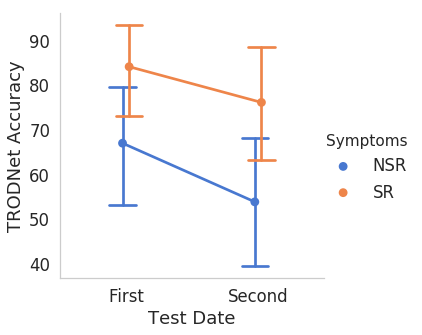

In [219]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.despine(offset=10, trim=True)
ax = sns.catplot(x = 'TestD', hue='Symptoms', data = ex[(ex.group == 'conc') & (ex.TestName == 'TRODNet')], 
                 dodge=True, kind='point', 
                 y = 'value', 
                 sharey=False, 
                 order= ['First','Second'],
                 capsize=.2, palette="muted", aspect=1)
ax.set(xlabel='Test Date', ylabel='TRODNet Accuracy')
ax.savefig('TestingAndAccuracy.eps')

<Figure size 432x288 with 0 Axes>

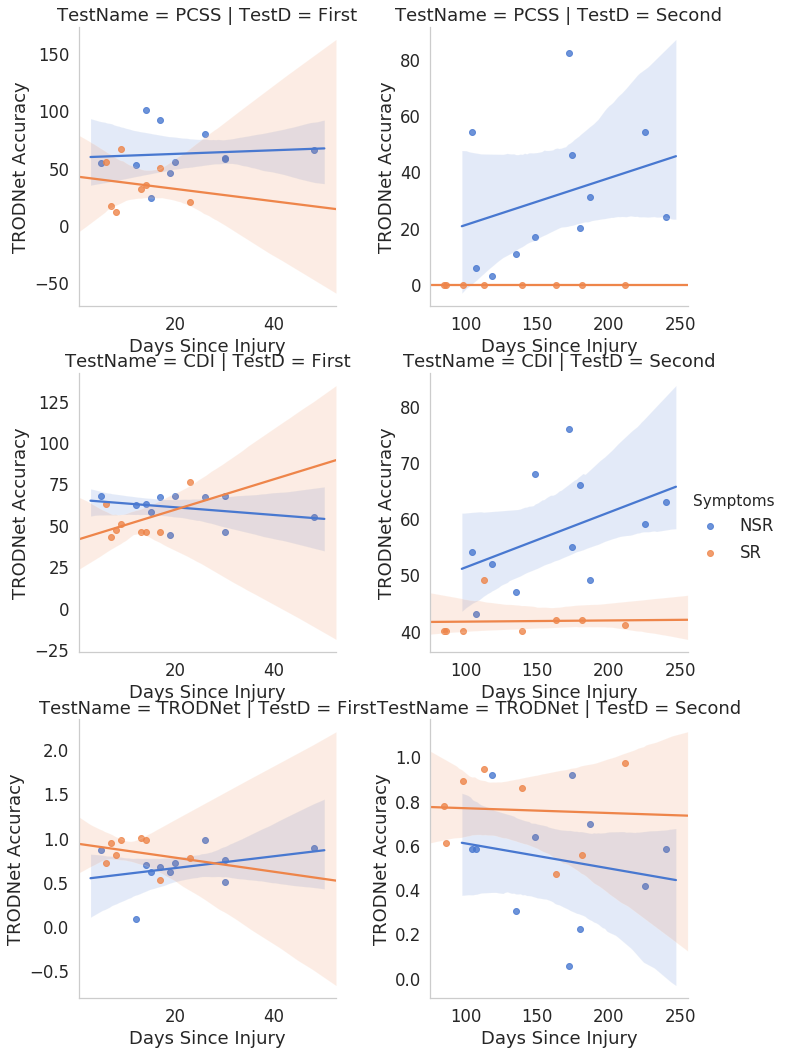

In [234]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.despine(offset=10, trim=True)
ax = sns.lmplot(x = 'Number',  col = 'TestD', row = 'TestName', hue = 'Symptoms', data = ex[(ex.group == 'conc')],  
                y = 'value', 
                ci = 95, palette="muted",
                sharex = False,
                sharey = False)
ax.set(xlabel='Days Since Injury', ylabel='TRODNet Accuracy')
ax.savefig('DaysInteractions.pdf')

## Visualization Tools

### Plot kernels from learned model

In [ ]:
kernels = tf.get_collection(tf.GraphKeys.VARIABLES, 'feature_extractor/conv3/kernel')[0]

In [ ]:
kernel_np = np.squeeze(sess.run(kernels))

In [ ]:
fig, axs = plt.subplots(1, maps)
for i in range(maps):
    mne.viz.plot_topomap(kernel_np[:, i],info, axes = axs[i])
    
fig

## SHAP Feature Importance

In [81]:
try:
    sess.close()
    tf.reset_default_graph()
except:
    pass

X, y, subs, sub_mapping = prep_data('CONT_CONC_YOUNG')

input_size = X.reshape(-1, X.shape[2], X.shape[-1]).shape[1:]
batch_size = 160
maps = 5

sess = tf.InteractiveSession()
model = CNNModel(nOfClasses = np.unique(y).shape[0], maps = maps, batch_size = batch_size)

scaler = main_loop(X, y, subs, verbose = False, interpretation=True)

In [84]:
b2p.compute_subject_averages()

In [85]:
conc = [b2p.subject_averages['concussed'][i] for i in ['Standard', 'Frequency Deviant', 'Duration Deviant']]
cont = [b2p.subject_averages['controls'][i] for i in ['Standard', 'Frequency Deviant', 'Duration Deviant']]

In [86]:
conc = np.concatenate([np.array([conc[0][j].data for j in range(26)])[:,:,128:460] for i in [0, 1, 2]], axis = 1)
cont = np.concatenate([np.array([cont[0][j].data for j in range(28)])[:,:,128:460] for i in [0, 1, 2]], axis = 1)

In [87]:
conc *= 1e6
cont *=1e6

In [88]:
conc_scaled = scaler.transform(conc.reshape((-1, conc.shape[1] * conc.shape[2]))).reshape((conc.shape[0], conc.shape[1], conc.shape[2]))
cont_scaled = scaler.transform(cont.reshape((-1, cont.shape[1] * cont.shape[2]))).reshape((cont.shape[0], cont.shape[1], cont.shape[2]))
grands = np.concatenate([conc_scaled, cont_scaled], axis = 0)

In [89]:
X_bg = np.vstack([X[i,:,:,:] for  i in range(X.shape[0])])
y_bg = y.flatten()
inds = np.random.choice(X_bg.shape[0], 500, replace=False)
y_sample = y_bg[inds]
X_sample = X_bg[inds]
X_sample_test = X_sample[1:4]

In [90]:
import shap

e = shap.DeepExplainer((model.X, model.p), X_sample, sess)

Using TensorFlow backend.


In [91]:
shap_values = e.shap_values(grands)

In [ ]:
# shap.image_plot(shap_values[0], -grands)

In [92]:
data_shaps = np.mean(np.absolute(shap_values[0]), 0)

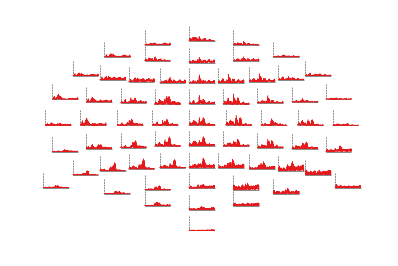

In [178]:
f = plt.figure()
ax = f.add_subplot(111)
ax = mne.EvokedArray(data_shaps[128:,:], info).plot_topo(show=True, axes=ax, ylim={'eeg':[0, 250]}, legend=False)
f.savefig('FDev.eps')

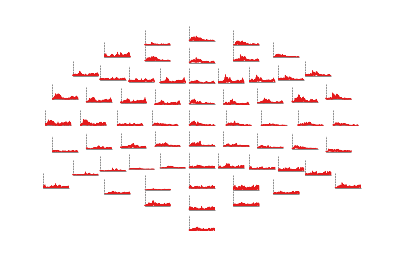

In [177]:
f = plt.figure()
ax = f.add_subplot(111)
mne.EvokedArray(data_shaps[64:128,:], info).plot_topo(show=True, axes=ax,ylim={'eeg':[0, 250]},layout=layout, legend=False)
f.savefig('DDev.eps')

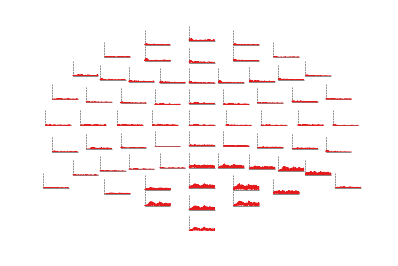

In [176]:
f = plt.figure()
ax = f.add_subplot(111)
ax = mne.EvokedArray(data_shaps[:64,:], info).plot_topo(show=True, axes=ax, ylim={'eeg':[0, 250]}, legend=False)
f.savefig('Std.eps')

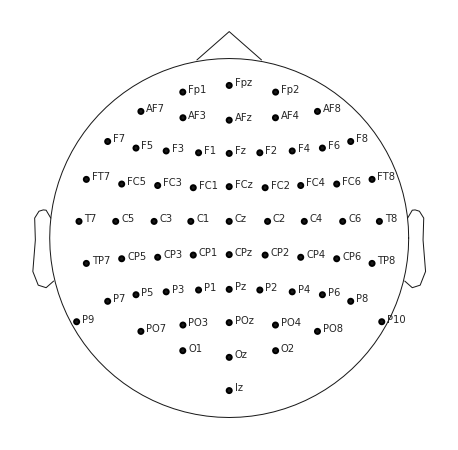

In [212]:
f = mne.viz.plot_sensors(info, show_names=True, title='');
f.savefig('Legend.eps')